In [8]:
import os, jax
import numpy as np
import jax.numpy as jnp

from jax import random
from asterion.nn import BayesianNN
from asterion.utils import PACKAGE_DIR
from scipy.stats import gaussian_kde

In [9]:
import numpyro.distributions as dist

In [10]:
import numpyro

In [11]:
bnn = BayesianNN.from_file(os.path.join(PACKAGE_DIR, 'data', 'tau_prior.nc'))

In [12]:
data = np.hstack([bnn.x_train, bnn.y_train])

In [363]:
rng = random.PRNGKey(0)
rng, key = random.split(rng)

num_data = data.shape[0]
num_train = int(0.8*num_data)
train_idx = random.choice(key, np.arange(num_data), shape=(num_train,), replace=False)
train = data[train_idx]

In [365]:
test = data[~train_idx]

In [13]:
import seaborn as sns
import pandas as pd

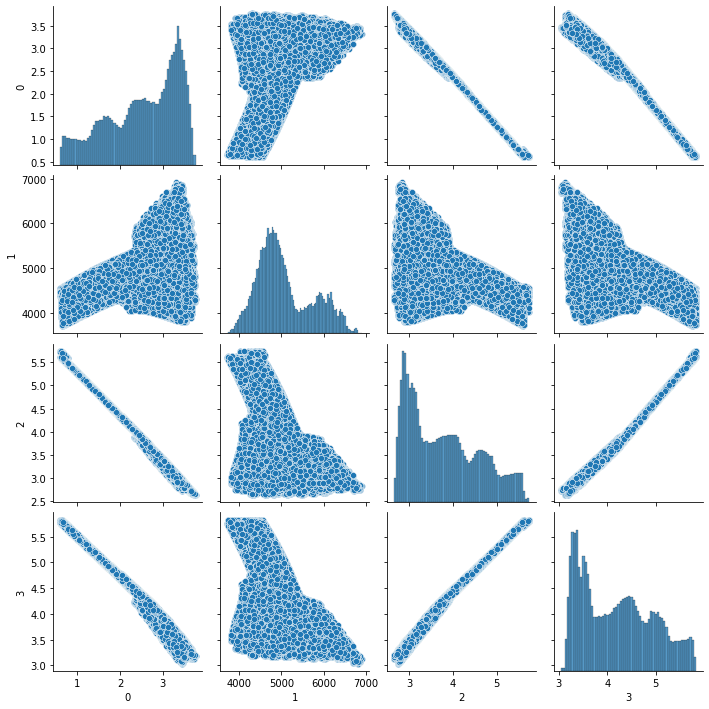

In [14]:
sns.pairplot(pd.DataFrame(data));

In [16]:
from sklearn.mixture import GaussianMixture

In [374]:
gm = GaussianMixture(n_components=4, random_state=0).fit(data)

In [375]:
num_samples = 5000
data_sample, _ = gm.sample(num_samples)

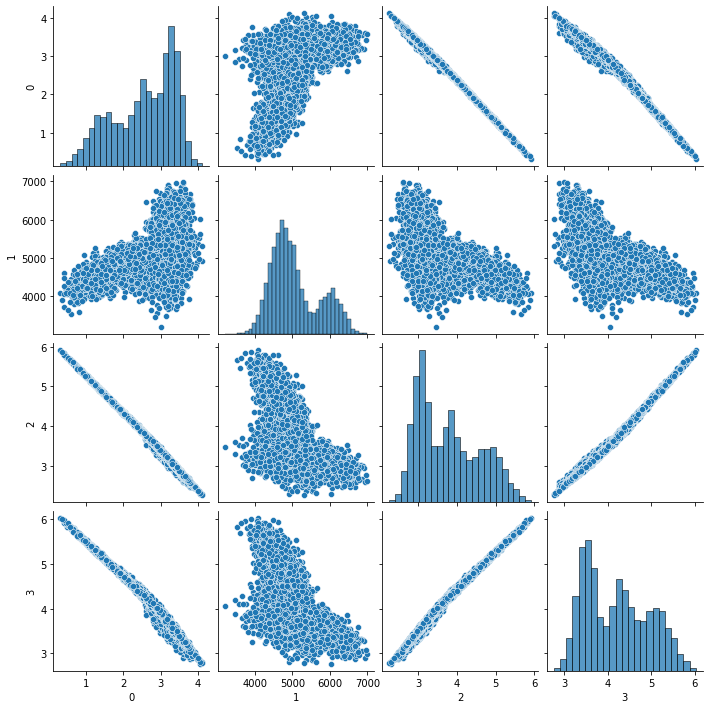

In [376]:
sns.pairplot(pd.DataFrame(data_sample));

In [377]:
loc = jnp.array(gm.means_)
cov = jnp.array(gm.covariances_)

def model(nu_max, nu_max_err, teff, teff_err):    
    assignment = numpyro.sample('assignment', dist.Categorical(gm.weights_))
    
    locp = loc[assignment]
    covp = cov[assignment]

    nu_max = numpyro.sample('nu_max', dist.Normal(nu_max, nu_max_err))
    log_nu_max = jnp.log10(nu_max)

    teff = numpyro.sample('teff', dist.Normal(teff, teff_err))

    loc0101 = locp[0:2]
    cov0101 = jnp.array([
        [covp[0, 0], covp[0, 1]],
        [covp[1, 0], covp[1, 1]]
    ])
                                       
    L = jax.scipy.linalg.cho_factor(cov0101, lower=True)
    A = jax.scipy.linalg.cho_solve(L, jnp.array([log_nu_max, teff]) - loc0101)
    
    loc2323 = locp[2:]
    cov2323 = jnp.array([
        [covp[2, 2], covp[2, 3]],
        [covp[3, 2], covp[3, 3]]
    ])  
    
    cov0123 = jnp.array([
        [covp[0, 2], covp[1, 2]],
        [covp[0, 3], covp[1, 3]]
    ])
    v = jax.scipy.linalg.cho_solve(L, cov0123.T)
    
    cond_loc = loc2323 + jnp.dot(cov0123, A)
    cond_cov = cov2323 - jnp.dot(cov0123, v) + 0.005 * jnp.eye(2)  # Add white noise
    numpyro.sample('log_tau', dist.MultivariateNormal(cond_loc, cond_cov))

In [378]:
from numpyro.infer import Predictive

In [379]:
rng, key = random.split(rng)

predictive = Predictive(model, num_samples=1000)

In [384]:
pred = predictive(key, 2188., 30., 5825., 50.)
# pred = predictive(key, 100., 1., 5000., 800.)  # teff = (5000, 800) a good uninformative prior

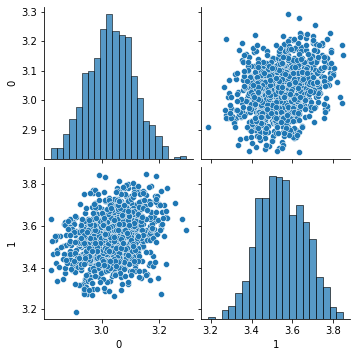

In [385]:
sns.pairplot(pd.DataFrame(pred['log_tau']));

In [386]:
df_pred = pd.DataFrame(np.vstack([data[:, [2, 3]], pred['log_tau']]))
df_pred[2] = 0
df_pred.iloc[data.shape[0]:, 2] = 1

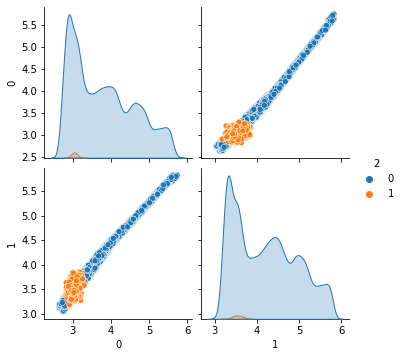

In [387]:
sns.pairplot(df_pred, vars=[0, 1], hue=2);

In [391]:
log_tau = pred['log_tau'] - 6

In [392]:
log_tau.mean(axis=0)

DeviceArray([-2.96667318, -2.45218589], dtype=float64)

In [393]:
log_tau.std(axis=0, ddof=1)

DeviceArray([0.07993114, 0.11273309], dtype=float64)

In [398]:
d = {
    "loc": gm.means_,
    "cov": gm.covariances_,
    "weights": gm.weights_,
}
d

{'loc': array([[3.21707973e+00, 6.06545680e+03, 3.07287855e+00, 3.48599734e+00],
        [2.54691234e+00, 4.83659081e+03, 3.82659388e+00, 4.29677828e+00],
        [3.37467968e+00, 4.99321780e+03, 3.00907652e+00, 3.52206736e+00],
        [1.50187411e+00, 4.61453211e+03, 4.80374637e+00, 5.11142826e+00]]),
 'cov': array([[[ 4.74107689e-02,  2.10374753e+01, -4.50673626e-02,
          -4.29660982e-02],
         [ 2.10374753e+01,  8.67476626e+04, -3.09374296e+01,
          -4.05217581e+01],
         [-4.50673626e-02, -3.09374296e+01,  4.47311492e-02,
           4.40438337e-02],
         [-4.29660982e-02, -4.05217581e+01,  4.40438337e-02,
           4.57177839e-02]],
 
        [[ 6.67087500e-02,  1.70161389e+00, -6.39337291e-02,
          -5.62773436e-02],
         [ 1.70161389e+00,  8.45548647e+04, -6.47441494e+00,
          -1.00756761e+01],
         [-6.39337291e-02, -6.47441494e+00,  6.16228667e-02,
           5.45286708e-02],
         [-5.62773436e-02, -1.00756761e+01,  5.45286708e-02,
 

In [405]:
from pprint import pformat

In [407]:
with open("../asterion/data/data.py", 'a') as file:
    file.write(f"tau_prior = {pformat(d)}")